<a href="https://colab.research.google.com/github/SD325/NASA_Internship_2020/blob/master/NASA_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Imports
import joblib
import pickle
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


# Working Directory 
BASE_DIR = '/content/drive/My Drive/data/NASA_2020/'

# Load and Split Data

In [ ]:
with open(BASE_DIR + 'X_data.pkl', 'rb') as f:
  X = pickle.load(f)
  print(f'Loaded X. {X.shape}')

with open(BASE_DIR + 'y_data.pkl', 'rb') as f:
  y = pickle.load(f)
  print(f'Loaded y. {y.shape}')

Loaded X. (667630, 47)
Loaded y. (667630, 4)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"train: {X_train.shape} {y_train.shape}")
print(f"test: {X_test.shape} {y_test.shape}")

train: (534104, 47) (534104, 4)
test: (133526, 47) (133526, 4)


# Build and Train Model

In [ ]:
# weighted loss function
import keras.backend as K

def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    def weighted_loss(y_true, y_pred):
        loss = 0.0
        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss += K.mean(-(pos_weights[i]*y_true[:, i]*K.log(y_pred[:, i]+epsilon)
                             + neg_weights[i]*(1-y_true[:, i])*K.log((1-y_pred[:, i])+epsilon)))
        return loss
    return weighted_loss

neg_weights = np.mean(y_train, axis=0)
pos_weights = 1 - neg_weights

Using TensorFlow backend.


In [ ]:
model = keras.models.Sequential([
        layers.InputLayer(input_shape=(47,)),
        layers.Dense(128, activation=tf.nn.relu), 
        layers.Dense(128, activation=tf.nn.relu),
        layers.Dense(32, activation=tf.nn.relu),
        layers.Dense(4, activation=tf.nn.softmax)
    ])

model.compile(optimizer='adam',
              loss=get_weighted_loss(pos_weights, neg_weights),
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5)

Epoch 1/5
16691/16691 [==============================] - 35s 2ms/step - loss: 0.0401 - accuracy: 0.9315 - val_loss: 0.0439 - val_accuracy: 0.9060
Epoch 2/5
16691/16691 [==============================] - 35s 2ms/step - loss: 0.0369 - accuracy: 0.9360 - val_loss: 0.0366 - val_accuracy: 0.9454
Epoch 3/5
16691/16691 [==============================] - 35s 2ms/step - loss: 0.0359 - accuracy: 0.9380 - val_loss: 0.0367 - val_accuracy: 0.9429
Epoch 4/5
16691/16691 [==============================] - 35s 2ms/step - loss: 0.0350 - accuracy: 0.9399 - val_loss: 0.0352 - val_accuracy: 0.9416
Epoch 5/5
16691/16691 [==============================] - 34s 2ms/step - loss: 0.0350 - accuracy: 0.9393 - val_loss: 0.0363 - val_accuracy: 0.9410


In [ ]:
y_pred = model.predict(X_test)

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

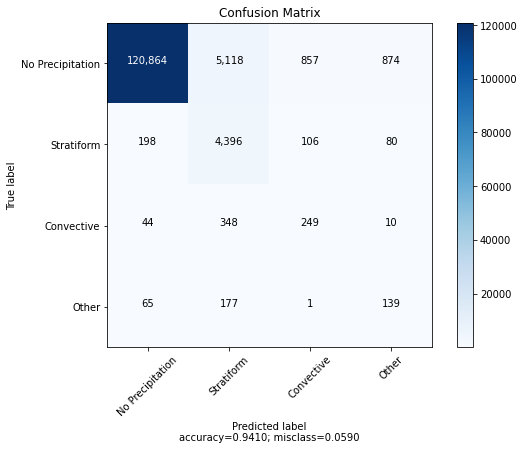

In [ ]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

plot_confusion_matrix(cm           = conf_mat, 
                      normalize    = False,
                      target_names = ['No Precipitation', 'Stratiform', 'Convective', 'Other'],
                      title        = "Confusion Matrix")

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

def get_roc_curve(labels, y_true, y_pred):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = y_true[:, i]
            pred = y_pred[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals

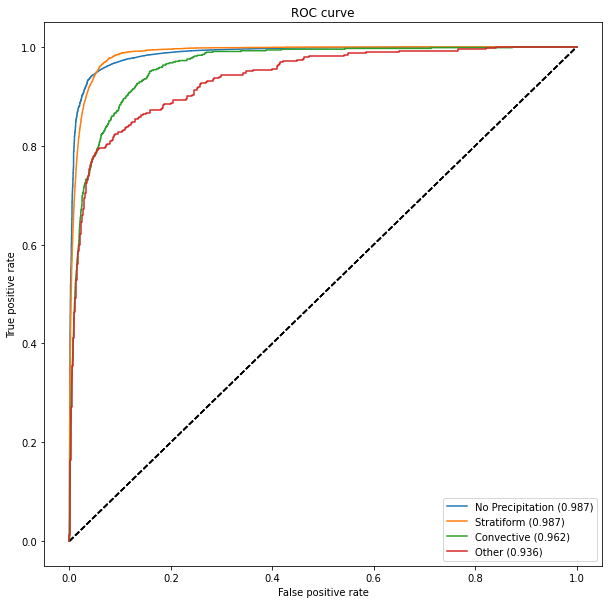

In [ ]:
auc_rocs = get_roc_curve(['No Precipitation', 'Stratiform', 'Convective', 'Other'], y_test, y_pred)